Бенчмарк версия кода

In [1]:
%%writefile benchmark.cu
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <chrono>
#include <cuda_runtime.h>

#ifndef M_PI
#define M_PI 3.14159265358979323846
#endif

#define CSC(call) \
do { \
    cudaError_t res = call; \
    if (res != cudaSuccess) { \
        fprintf(stderr, "ERROR in %s:%d. Message: %s\n", __FILE__, __LINE__, cudaGetErrorString(res)); \
        exit(0); \
    } \
} while(0)

typedef unsigned char uchar;

struct vec3 { double x, y, z; };
struct trig { vec3 a, b, c; uchar4 color; };

__host__ __device__ double dot(vec3 a, vec3 b) {
    return a.x * b.x + a.y * b.y + a.z * b.z;
}

__host__ __device__ vec3 prod(vec3 a, vec3 b) {
    vec3 result;
    result.x = a.y * b.z - a.z * b.y;
    result.y = a.z * b.x - a.x * b.z;
    result.z = a.x * b.y - a.y * b.x;
    return result;
}

__host__ __device__ vec3 norm(vec3 v) {
    double l = sqrt(dot(v, v));
    vec3 result;
    if (l < 1e-10) {
        result.x = result.y = result.z = 0;
    } else {
        result.x = v.x / l;
        result.y = v.y / l;
        result.z = v.z / l;
    }
    return result;
}

__host__ __device__ vec3 diff(vec3 a, vec3 b) {
    vec3 result;
    result.x = a.x - b.x;
    result.y = a.y - b.y;
    result.z = a.z - b.z;
    return result;
}

__host__ __device__ vec3 add(vec3 a, vec3 b) {
    vec3 result;
    result.x = a.x + b.x;
    result.y = a.y + b.y;
    result.z = a.z + b.z;
    return result;
}

__host__ __device__ vec3 mult(vec3 a, vec3 b, vec3 c, vec3 v) {
    vec3 result;
    result.x = a.x * v.x + b.x * v.y + c.x * v.z;
    result.y = a.y * v.x + b.y * v.y + c.y * v.z;
    result.z = a.z * v.x + b.z * v.y + c.z * v.z;
    return result;
}

__host__ __device__ vec3 scale(vec3 v, double s) {
    vec3 result;
    result.x = v.x * s;
    result.y = v.y * s;
    result.z = v.z * s;
    return result;
}

__host__ __device__ bool intersect_triangle(vec3 pos, vec3 dir, trig t, double* ts) {
    vec3 e1 = diff(t.b, t.a);
    vec3 e2 = diff(t.c, t.a);
    vec3 p = prod(dir, e2);
    double div = dot(p, e1);

    if (fabs(div) < 1e-10) return false;

    vec3 tv = diff(pos, t.a);
    double u = dot(p, tv) / div;
    if (u < 0.0 || u > 1.0) return false;

    vec3 q = prod(tv, e1);
    double v = dot(q, dir) / div;
    if (v < 0.0 || v + u > 1.0) return false;

    double t_val = dot(q, e2) / div;
    if (t_val < 1e-6) return false;

    *ts = t_val;
    return true;
}

__global__ void render_kernel(vec3 pc, vec3 pv, int w, int h, double angle,
                              trig* trigs, int num_trigs, vec3 light_pos, uchar4* data) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;

    if (idx >= w || idy >= h) return;

    double dw = 2.0 / (w - 1);
    double dh = 2.0 / (h - 1);
    double z = 1.0 / tan(angle * M_PI / 360.0);

    vec3 up_vec;
    up_vec.x = 0.0; up_vec.y = 1.0; up_vec.z = 0.0;

    vec3 bz = norm(diff(pv, pc));
    vec3 bx = norm(prod(bz, up_vec));
    vec3 by = prod(bx, bz);

    vec3 v;
    v.x = -1.0 + dw * idx;
    v.y = (-1.0 + dh * idy) * h / w;
    v.z = z;
    vec3 dir = norm(mult(bx, by, bz, v));

    int k_min = -1;
    double ts_min = 1e20;

    for (int k = 0; k < num_trigs; k++) {
        double ts;
        if (intersect_triangle(pc, dir, trigs[k], &ts)) {
            if (ts < ts_min) {
                k_min = k;
                ts_min = ts;
            }
        }
    }

    uchar4 color;
    if (k_min == -1) {
        color = make_uchar4(135, 206, 235, 0);
    } else {
        vec3 hit_point = add(pc, scale(dir, ts_min));
        vec3 e1 = diff(trigs[k_min].b, trigs[k_min].a);
        vec3 e2 = diff(trigs[k_min].c, trigs[k_min].a);
        vec3 normal = norm(prod(e1, e2));

        vec3 to_light = norm(diff(light_pos, hit_point));
        double diffuse = fmax(0.3, dot(normal, to_light));

        color = trigs[k_min].color;
        color.x = (uchar)(color.x * diffuse);
        color.y = (uchar)(color.y * diffuse);
        color.z = (uchar)(color.z * diffuse);
    }

    data[(h - 1 - idy) * w + idx] = color;
}

void render_cpu(vec3 pc, vec3 pv, int w, int h, double angle,
                trig* trigs, int num_trigs, vec3 light_pos, uchar4* data) {
    double dw = 2.0 / (w - 1);
    double dh = 2.0 / (h - 1);
    double z = 1.0 / tan(angle * M_PI / 360.0);

    vec3 up_vec;
    up_vec.x = 0.0; up_vec.y = 1.0; up_vec.z = 0.0;

    vec3 bz = norm(diff(pv, pc));
    vec3 bx = norm(prod(bz, up_vec));
    vec3 by = prod(bx, bz);

    for (int i = 0; i < w; i++) {
        for (int j = 0; j < h; j++) {
            vec3 v;
            v.x = -1.0 + dw * i;
            v.y = (-1.0 + dh * j) * h / w;
            v.z = z;
            vec3 dir = norm(mult(bx, by, bz, v));

            int k_min = -1;
            double ts_min = 1e20;

            for (int k = 0; k < num_trigs; k++) {
                double ts;
                if (intersect_triangle(pc, dir, trigs[k], &ts)) {
                    if (ts < ts_min) {
                        k_min = k;
                        ts_min = ts;
                    }
                }
            }

            uchar4 color;
            if (k_min == -1) {
                color = make_uchar4(135, 206, 235, 0);
            } else {
                vec3 hit_point = add(pc, scale(dir, ts_min));
                vec3 e1 = diff(trigs[k_min].b, trigs[k_min].a);
                vec3 e2 = diff(trigs[k_min].c, trigs[k_min].a);
                vec3 normal = norm(prod(e1, e2));

                vec3 to_light = norm(diff(light_pos, hit_point));
                double diffuse = fmax(0.3, dot(normal, to_light));

                color = trigs[k_min].color;
                color.x = (uchar)(color.x * diffuse);
                color.y = (uchar)(color.y * diffuse);
                color.z = (uchar)(color.z * diffuse);
            }

            data[(h - 1 - j) * w + i] = color;
        }
    }
}

void add_tetrahedron(trig* trigs, int* idx, vec3 center, double radius, uchar4 color) {
    double a = radius * sqrt(8.0/3.0);
    double h = a * sqrt(2.0/3.0);

    vec3 v0 = add(center, (vec3){0, h/2, 0});
    vec3 v1 = add(center, (vec3){-a/2, -h/2, a/(2*sqrt(3))});
    vec3 v2 = add(center, (vec3){a/2, -h/2, a/(2*sqrt(3))});
    vec3 v3 = add(center, (vec3){0, -h/2, -a/sqrt(3)});

    trigs[(*idx)++] = (trig){v0, v1, v2, color};
    trigs[(*idx)++] = (trig){v0, v2, v3, color};
    trigs[(*idx)++] = (trig){v0, v3, v1, color};
    trigs[(*idx)++] = (trig){v1, v3, v2, color};
}

void add_hexahedron(trig* trigs, int* idx, vec3 center, double radius, uchar4 color) {
    double a = radius * 2.0 / sqrt(3.0);
    double h = a / 2.0;

    vec3 vertices[8] = {
        add(center, (vec3){-h, -h, -h}), add(center, (vec3){h, -h, -h}),
        add(center, (vec3){h, h, -h}), add(center, (vec3){-h, h, -h}),
        add(center, (vec3){-h, -h, h}), add(center, (vec3){h, -h, h}),
        add(center, (vec3){h, h, h}), add(center, (vec3){-h, h, h})
    };

    int faces[12][3] = {
        {0,1,2}, {0,2,3}, {4,6,5}, {4,7,6},
        {0,4,5}, {0,5,1}, {2,6,7}, {2,7,3},
        {0,3,7}, {0,7,4}, {1,5,6}, {1,6,2}
    };

    for (int i = 0; i < 12; i++) {
        trigs[(*idx)++] = (trig){vertices[faces[i][0]], vertices[faces[i][1]],
                                 vertices[faces[i][2]], color};
    }
}

void add_dodecahedron(trig* trigs, int* idx, vec3 center, double radius, uchar4 color) {
    double phi = (1.0 + sqrt(5.0)) / 2.0;
    double a = radius / sqrt(3.0);

    vec3 v[20];
    v[0] = add(center, scale((vec3){1, 1, 1}, a));
    v[1] = add(center, scale((vec3){1, 1, -1}, a));
    v[2] = add(center, scale((vec3){1, -1, 1}, a));
    v[3] = add(center, scale((vec3){1, -1, -1}, a));
    v[4] = add(center, scale((vec3){-1, 1, 1}, a));
    v[5] = add(center, scale((vec3){-1, 1, -1}, a));
    v[6] = add(center, scale((vec3){-1, -1, 1}, a));
    v[7] = add(center, scale((vec3){-1, -1, -1}, a));

    v[8] = add(center, scale((vec3){0, phi, 1.0/phi}, a));
    v[9] = add(center, scale((vec3){0, phi, -1.0/phi}, a));
    v[10] = add(center, scale((vec3){0, -phi, 1.0/phi}, a));
    v[11] = add(center, scale((vec3){0, -phi, -1.0/phi}, a));

    v[12] = add(center, scale((vec3){1.0/phi, 0, phi}, a));
    v[13] = add(center, scale((vec3){-1.0/phi, 0, phi}, a));
    v[14] = add(center, scale((vec3){1.0/phi, 0, -phi}, a));
    v[15] = add(center, scale((vec3){-1.0/phi, 0, -phi}, a));

    v[16] = add(center, scale((vec3){phi, 1.0/phi, 0}, a));
    v[17] = add(center, scale((vec3){phi, -1.0/phi, 0}, a));
    v[18] = add(center, scale((vec3){-phi, 1.0/phi, 0}, a));
    v[19] = add(center, scale((vec3){-phi, -1.0/phi, 0}, a));

    int faces[12][5] = {
        {0,8,9,1,16}, {0,12,13,4,8}, {0,16,17,2,12},
        {8,4,18,5,9}, {12,2,10,6,13}, {16,1,14,3,17},
        {9,5,15,14,1}, {6,10,11,7,19}, {4,13,6,19,18},
        {2,17,3,11,10}, {5,18,19,7,15}, {3,14,15,7,11}
    };

    for (int i = 0; i < 12; i++) {
        trigs[(*idx)++] = (trig){v[faces[i][0]], v[faces[i][1]], v[faces[i][2]], color};
        trigs[(*idx)++] = (trig){v[faces[i][0]], v[faces[i][2]], v[faces[i][3]], color};
        trigs[(*idx)++] = (trig){v[faces[i][0]], v[faces[i][3]], v[faces[i][4]], color};
    }
}

void build_scene(trig* scene, int* trig_count, int complexity) {
    *trig_count = 0;

    vec3 floor_v[4] = {
        {-8.0, -2.0, -8.0}, {-8.0, -2.0, 8.0},
        {8.0, -2.0, 8.0}, {8.0, -2.0, -8.0}
    };
    uchar4 floor_col = make_uchar4(178, 178, 178, 0);
    scene[(*trig_count)++] = (trig){floor_v[0], floor_v[1], floor_v[2], floor_col};
    scene[(*trig_count)++] = (trig){floor_v[0], floor_v[2], floor_v[3], floor_col};

    if (complexity >= 1) {
        add_tetrahedron(scene, trig_count, (vec3){-2.5, 0, 0}, 1.2, make_uchar4(255, 51, 51, 0));
    }
    if (complexity >= 2) {
        add_hexahedron(scene, trig_count, (vec3){0, 1.2, 0}, 1.0, make_uchar4(51, 255, 51, 0));
    }
    if (complexity >= 3) {
        add_dodecahedron(scene, trig_count, (vec3){2.5, 0, 0}, 1.2, make_uchar4(51, 51, 255, 0));
    }
}

int main() {
    printf("\n======================================================================\n");
    printf("ИССЛЕДОВАНИЕ ПРОИЗВОДИТЕЛЬНОСТИ RAY TRACING\n");
    printf("======================================================================\n\n");

    // TEST 1: Влияние конфигурации grid/block
    printf("=== ЧАСТЬ 1: Влияние конфигурации kernel на производительность ===\n\n");

    int test_widths[]  = {300, 640, 2048};
    int test_heights[] = {300, 640, 2048};
    int grid_sizes[] = {1, 8, 64, 256};
    int block_sizes[] = {32, 64, 128, 256, 512};

    for (int t = 0; t < 3; t++) {
        int w = test_widths[t], h = test_heights[t];
        size_t pixels = (size_t)w * h;

        printf("TEST %d (%dx%d)\n", t + 1, w, h);
        printf("%zu\n", pixels);

        const int MAX_TRIGS = 1000;
        trig* scene = (trig*)malloc(sizeof(trig) * MAX_TRIGS);
        int trig_count = 0;
        build_scene(scene, &trig_count, 3);

        vec3 pc = {8.0, 4.5, 0.0};
        vec3 pv = {0.0, 0.8, 0.0};
        vec3 light = {8.0, 15.0, 8.0};
        double fov = 120.0;

        uchar4* data = (uchar4*)malloc(sizeof(uchar4) * pixels);
        trig* d_scene;
        uchar4* d_data;

        CSC(cudaMalloc(&d_scene, sizeof(trig) * trig_count));
        CSC(cudaMalloc(&d_data, sizeof(uchar4) * pixels));
        CSC(cudaMemcpy(d_scene, scene, sizeof(trig) * trig_count, cudaMemcpyHostToDevice));

        printf("GPU timings (in ms):\n");

        for (int gi = 0; gi < 4; gi++) {
            for (int bi = 0; bi < 5; bi++) {
                int g = grid_sizes[gi];
                int b = block_sizes[bi];

                int block_x = b / 32;
                if (block_x < 1) block_x = 1;
                int block_y = 32;

                dim3 grid((unsigned int)g, (unsigned int)g);
                dim3 block((unsigned int)block_x, (unsigned int)block_y);

                cudaEvent_t start, stop;
                CSC(cudaEventCreate(&start));
                CSC(cudaEventCreate(&stop));
                CSC(cudaEventRecord(start, 0));

                render_kernel<<<grid, block>>>(pc, pv, w, h, fov, d_scene, trig_count, light, d_data);
                CSC(cudaGetLastError());
                CSC(cudaDeviceSynchronize());

                CSC(cudaEventRecord(stop, 0));
                CSC(cudaEventSynchronize(stop));

                float gpuTime = 0.0f;
                CSC(cudaEventElapsedTime(&gpuTime, start, stop));

                printf("|grids: %d|blocks: %d|time: %.6f ms|\n", g, b, gpuTime);

                CSC(cudaEventDestroy(start));
                CSC(cudaEventDestroy(stop));
            }
        }

        auto cpuStart = std::chrono::high_resolution_clock::now();
        render_cpu(pc, pv, w, h, fov, scene, trig_count, light, data);
        auto cpuEnd = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> cpuTime = cpuEnd - cpuStart;
        printf("CPU: %.6f ms\n", cpuTime.count());

        CSC(cudaFree(d_scene));
        CSC(cudaFree(d_data));
        free(data);
        free(scene);
        printf("\n");
    }

    // TEST 2: Влияние сложности сцены
    printf("\n=== ЧАСТЬ 2: Влияние сложности сцены (кол-во треугольников) ===\n\n");

    int w = 640, h = 640;
    size_t pixels = (size_t)w * h;
    vec3 pc = {8.0, 4.5, 0.0};
    vec3 pv = {0.0, 0.8, 0.0};
    vec3 light = {8.0, 15.0, 8.0};
    double fov = 120.0;

    const char* complexity_names[] = {"Только пол (2 треугольника)",
                                       "Пол + Тетраэдр (6 треугольников)",
                                       "Пол + Тетраэдр + Гексаэдр (18 треугольников)",
                                       "Полная сцена (54 треугольника)"};

    for (int complexity = 0; complexity <= 3; complexity++) {
        const int MAX_TRIGS = 1000;
        trig* scene = (trig*)malloc(sizeof(trig) * MAX_TRIGS);
        int trig_count = 0;
        build_scene(scene, &trig_count, complexity);

        printf("Сцена: %s\n", complexity_names[complexity]);

        uchar4* data = (uchar4*)malloc(sizeof(uchar4) * pixels);
        trig* d_scene;
        uchar4* d_data;

        CSC(cudaMalloc(&d_scene, sizeof(trig) * trig_count));
        CSC(cudaMalloc(&d_data, sizeof(uchar4) * pixels));
        CSC(cudaMemcpy(d_scene, scene, sizeof(trig) * trig_count, cudaMemcpyHostToDevice));

        dim3 block(16, 16);
        dim3 grid((w + block.x - 1) / block.x, (h + block.y - 1) / block.y);

        cudaEvent_t start, stop;
        CSC(cudaEventCreate(&start));
        CSC(cudaEventCreate(&stop));
        CSC(cudaEventRecord(start, 0));

        render_kernel<<<grid, block>>>(pc, pv, w, h, fov, d_scene, trig_count, light, d_data);
        CSC(cudaGetLastError());
        CSC(cudaDeviceSynchronize());

        CSC(cudaEventRecord(stop, 0));
        CSC(cudaEventSynchronize(stop));

        float gpuTime = 0.0f;
        CSC(cudaEventElapsedTime(&gpuTime, start, stop));

        auto cpuStart = std::chrono::high_resolution_clock::now();
        render_cpu(pc, pv, w, h, fov, scene, trig_count, light, data);
        auto cpuEnd = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> cpuTime = cpuEnd - cpuStart;

        printf("GPU: %.6f ms | CPU: %.6f ms | Ускорение: %.2fx\n\n",
               gpuTime, cpuTime.count(), cpuTime.count() / gpuTime);

        CSC(cudaEventDestroy(start));
        CSC(cudaEventDestroy(stop));
        CSC(cudaFree(d_scene));
        CSC(cudaFree(d_data));
        free(data);
        free(scene);
    }

    // TEST 3: Влияние ракурса камеры
    printf("\n=== ЧАСТЬ 3: Влияние ракурса камеры ===\n\n");

    const int MAX_TRIGS = 1000;
    trig* scene = (trig*)malloc(sizeof(trig) * MAX_TRIGS);
    int trig_count = 0;
    build_scene(scene, &trig_count, 3);

    vec3 cameras[] = {
        {8.0, 4.5, 0.0},    // Фронтальный вид
        {0.0, 10.0, 8.0},   // Вид сверху
        {3.0, 1.0, 3.0},    // Близкий ракурс
        {15.0, 5.0, 15.0}   // Дальний ракурс
    };

    const char* camera_names[] = {"Фронтальный вид", "Вид сверху", "Близкий ракурс", "Дальний ракурс"};

    for (int cam_idx = 0; cam_idx < 4; cam_idx++) {
        vec3 pc = cameras[cam_idx];
        vec3 pv = {0.0, 0.8, 0.0};

        printf("Ракурс: %s (камера: %.1f, %.1f, %.1f)\n",
               camera_names[cam_idx], pc.x, pc.y, pc.z);

        uchar4* data = (uchar4*)malloc(sizeof(uchar4) * pixels);
        trig* d_scene;
        uchar4* d_data;

        CSC(cudaMalloc(&d_scene, sizeof(trig) * trig_count));
        CSC(cudaMalloc(&d_data, sizeof(uchar4) * pixels));
        CSC(cudaMemcpy(d_scene, scene, sizeof(trig) * trig_count, cudaMemcpyHostToDevice));

        dim3 block(16, 16);
        dim3 grid((w + block.x - 1) / block.x, (h + block.y - 1) / block.y);

        cudaEvent_t start, stop;
        CSC(cudaEventCreate(&start));
        CSC(cudaEventCreate(&stop));
        CSC(cudaEventRecord(start, 0));

        render_kernel<<<grid, block>>>(pc, pv, w, h, fov, d_scene, trig_count, light, d_data);
        CSC(cudaGetLastError());
        CSC(cudaDeviceSynchronize());

        CSC(cudaEventRecord(stop, 0));
        CSC(cudaEventSynchronize(stop));

        float gpuTime = 0.0f;
        CSC(cudaEventElapsedTime(&gpuTime, start, stop));

        printf("GPU: %.6f ms\n\n", gpuTime);

        CSC(cudaEventDestroy(start));
        CSC(cudaEventDestroy(stop));
        CSC(cudaFree(d_scene));
        CSC(cudaFree(d_data));
        free(data);
    }

    free(scene);

    printf("======================================================================\n");
    printf("БЕНЧМАРК ЗАВЕРШЁН\n");
    printf("======================================================================\n");

    return 0;
}

Writing benchmark.cu


In [2]:
%%shell
# Компиляция бенчмарка
nvcc -o benchmark benchmark.cu -arch=sm_75 -std=c++11 -O2

# Запуск
./benchmark > results.txt 2>&1
cat results.txt

# Результаты сохранятся в results.txt


ИССЛЕДОВАНИЕ ПРОИЗВОДИТЕЛЬНОСТИ RAY TRACING

=== ЧАСТЬ 1: Влияние конфигурации kernel на производительность ===

TEST 1 (300x300)
90000
GPU timings (in ms):
|grids: 1|blocks: 32|time: 0.464896 ms|
|grids: 1|blocks: 64|time: 0.198688 ms|
|grids: 1|blocks: 128|time: 0.304608 ms|
|grids: 1|blocks: 256|time: 0.578688 ms|
|grids: 1|blocks: 512|time: 1.136896 ms|
|grids: 8|blocks: 32|time: 0.198336 ms|
|grids: 8|blocks: 64|time: 0.298496 ms|
|grids: 8|blocks: 128|time: 0.569344 ms|
|grids: 8|blocks: 256|time: 1.097472 ms|
|grids: 8|blocks: 512|time: 2.224096 ms|
|grids: 64|blocks: 32|time: 1.113344 ms|
|grids: 64|blocks: 64|time: 2.133888 ms|
|grids: 64|blocks: 128|time: 4.328320 ms|
|grids: 64|blocks: 256|time: 5.042176 ms|
|grids: 64|blocks: 512|time: 5.404640 ms|
|grids: 256|blocks: 32|time: 4.500736 ms|
|grids: 256|blocks: 64|time: 5.113824 ms|
|grids: 256|blocks: 128|time: 5.052608 ms|
|grids: 256|blocks: 256|time: 5.037184 ms|
|grids: 256|blocks: 512|time: 5.368640 ms|
CPU: 61.088543 

Основная версия кода (не бенчмарк), которая используется для генерации скриншотов

In [3]:
%%writefile raytracer.cu
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <string.h>
#include <time.h>

#ifndef M_PI
#define M_PI 3.14159265358979323846
#endif

typedef unsigned char uchar;

struct vec3 {
    double x, y, z;
};

struct trig {
    vec3 a, b, c;
    uchar4 color;
};

__host__ __device__ double dot(vec3 a, vec3 b) {
    return a.x * b.x + a.y * b.y + a.z * b.z;
}

__host__ __device__ vec3 prod(vec3 a, vec3 b) {
    return {a.y * b.z - a.z * b.y, a.z * b.x - a.x * b.z, a.x * b.y - a.y * b.x};
}

__host__ __device__ vec3 norm(vec3 v) {
    double l = sqrt(dot(v, v));
    if (l < 1e-10) return {0, 0, 0};
    return {v.x / l, v.y / l, v.z / l};
}

__host__ __device__ vec3 diff(vec3 a, vec3 b) {
    return {a.x - b.x, a.y - b.y, a.z - b.z};
}

__host__ __device__ vec3 add(vec3 a, vec3 b) {
    return {a.x + b.x, a.y + b.y, a.z + b.z};
}

__host__ __device__ vec3 mult(vec3 a, vec3 b, vec3 c, vec3 v) {
    return {
        a.x * v.x + b.x * v.y + c.x * v.z,
        a.y * v.x + b.y * v.y + c.y * v.z,
        a.z * v.x + b.z * v.y + c.z * v.z
    };
}

__host__ __device__ vec3 scale(vec3 v, double s) {
    return {v.x * s, v.y * s, v.z * s};
}

__host__ __device__ bool intersect_triangle(vec3 pos, vec3 dir, trig t, double& ts) {
    vec3 e1 = diff(t.b, t.a);
    vec3 e2 = diff(t.c, t.a);
    vec3 p = prod(dir, e2);
    double div = dot(p, e1);

    if (fabs(div) < 1e-10)
        return false;

    vec3 tv = diff(pos, t.a);
    double u = dot(p, tv) / div;
    if (u < 0.0 || u > 1.0)
        return false;

    vec3 q = prod(tv, e1);
    double v = dot(q, dir) / div;
    if (v < 0.0 || v + u > 1.0)
        return false;

    double t_val = dot(q, e2) / div;
    if (t_val < 1e-6)
        return false;

    ts = t_val;
    return true;
}

__global__ void render_kernel(vec3 pc, vec3 pv, int w, int h, double angle,
                              trig* trigs, int num_trigs, vec3 light_pos, uchar4* data) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;

    if (idx >= w || idy >= h) return;

    double dw = 2.0 / (w - 1);
    double dh = 2.0 / (h - 1);
    double z = 1.0 / tan(angle * M_PI / 360.0);

    vec3 bz = norm(diff(pv, pc));
    vec3 bx = norm(prod(bz, {0.0, 1.0, 0.0}));
    vec3 by = prod(bx, bz);

    vec3 v = {-1.0 + dw * idx, (-1.0 + dh * idy) * h / w, z};
    vec3 dir = norm(mult(bx, by, bz, v));

    int k_min = -1;
    double ts_min = 1e20;

    for (int k = 0; k < num_trigs; k++) {
        double ts;
        if (intersect_triangle(pc, dir, trigs[k], ts)) {
            if (ts < ts_min) {
                k_min = k;
                ts_min = ts;
            }
        }
    }

    uchar4 color;
    if (k_min == -1) {
        color = make_uchar4(135, 206, 235, 0);
    } else {
        vec3 hit_point = add(pc, scale(dir, ts_min));
        vec3 e1 = diff(trigs[k_min].b, trigs[k_min].a);
        vec3 e2 = diff(trigs[k_min].c, trigs[k_min].a);
        vec3 normal = norm(prod(e1, e2));

        vec3 to_light = norm(diff(light_pos, hit_point));
        double diffuse = fmax(0.3, dot(normal, to_light));

        color = trigs[k_min].color;
        color.x = (uchar)(color.x * diffuse);
        color.y = (uchar)(color.y * diffuse);
        color.z = (uchar)(color.z * diffuse);
    }

    data[(h - 1 - idy) * w + idx] = color;
}

void render_cpu(vec3 pc, vec3 pv, int w, int h, double angle,
                trig* trigs, int num_trigs, vec3 light_pos, uchar4* data) {
    double dw = 2.0 / (w - 1);
    double dh = 2.0 / (h - 1);
    double z = 1.0 / tan(angle * M_PI / 360.0);

    vec3 bz = norm(diff(pv, pc));
    vec3 bx = norm(prod(bz, {0.0, 1.0, 0.0}));
    vec3 by = prod(bx, bz);

    for (int i = 0; i < w; i++) {
        for (int j = 0; j < h; j++) {
            vec3 v = {-1.0 + dw * i, (-1.0 + dh * j) * h / w, z};
            vec3 dir = norm(mult(bx, by, bz, v));

            int k_min = -1;
            double ts_min = 1e20;

            for (int k = 0; k < num_trigs; k++) {
                double ts;
                if (intersect_triangle(pc, dir, trigs[k], ts)) {
                    if (ts < ts_min) {
                        k_min = k;
                        ts_min = ts;
                    }
                }
            }

            uchar4 color;
            if (k_min == -1) {
                color = make_uchar4(135, 206, 235, 0);
            } else {
                vec3 hit_point = add(pc, scale(dir, ts_min));
                vec3 e1 = diff(trigs[k_min].b, trigs[k_min].a);
                vec3 e2 = diff(trigs[k_min].c, trigs[k_min].a);
                vec3 normal = norm(prod(e1, e2));

                vec3 to_light = norm(diff(light_pos, hit_point));
                double diffuse = fmax(0.3, dot(normal, to_light));

                color = trigs[k_min].color;
                color.x = (uchar)(color.x * diffuse);
                color.y = (uchar)(color.y * diffuse);
                color.z = (uchar)(color.z * diffuse);
            }

            data[(h - 1 - j) * w + i] = color;
        }
    }
}

void add_tetrahedron(trig* trigs, int& idx, vec3 center, double radius, uchar4 color) {
    double a = radius * sqrt(8.0/3.0);
    double h = a * sqrt(2.0/3.0);

    vec3 v0 = add(center, {0, h/2, 0});
    vec3 v1 = add(center, {-a/2, -h/2, a/(2*sqrt(3))});
    vec3 v2 = add(center, {a/2, -h/2, a/(2*sqrt(3))});
    vec3 v3 = add(center, {0, -h/2, -a/sqrt(3)});

    trigs[idx++] = {v0, v1, v2, color};
    trigs[idx++] = {v0, v2, v3, color};
    trigs[idx++] = {v0, v3, v1, color};
    trigs[idx++] = {v1, v3, v2, color};
}

void add_hexahedron(trig* trigs, int& idx, vec3 center, double radius, uchar4 color) {
    double a = radius * 2.0 / sqrt(3.0);
    double h = a / 2.0;

    vec3 vertices[8] = {
        add(center, {-h, -h, -h}), add(center, {h, -h, -h}),
        add(center, {h, h, -h}), add(center, {-h, h, -h}),
        add(center, {-h, -h, h}), add(center, {h, -h, h}),
        add(center, {h, h, h}), add(center, {-h, h, h})
    };

    int faces[12][3] = {
        {0,1,2}, {0,2,3}, {4,6,5}, {4,7,6},
        {0,4,5}, {0,5,1}, {2,6,7}, {2,7,3},
        {0,3,7}, {0,7,4}, {1,5,6}, {1,6,2}
    };

    for (int i = 0; i < 12; i++) {
        trigs[idx++] = {vertices[faces[i][0]], vertices[faces[i][1]],
                        vertices[faces[i][2]], color};
    }
}

void add_dodecahedron(trig* trigs, int& idx, vec3 center, double radius, uchar4 color) {
    double phi = (1.0 + sqrt(5.0)) / 2.0;
    double a = radius / sqrt(3.0);

    vec3 v[20];
    v[0] = add(center, scale({1, 1, 1}, a));
    v[1] = add(center, scale({1, 1, -1}, a));
    v[2] = add(center, scale({1, -1, 1}, a));
    v[3] = add(center, scale({1, -1, -1}, a));
    v[4] = add(center, scale({-1, 1, 1}, a));
    v[5] = add(center, scale({-1, 1, -1}, a));
    v[6] = add(center, scale({-1, -1, 1}, a));
    v[7] = add(center, scale({-1, -1, -1}, a));

    v[8] = add(center, scale({0, phi, 1.0/phi}, a));
    v[9] = add(center, scale({0, phi, -1.0/phi}, a));
    v[10] = add(center, scale({0, -phi, 1.0/phi}, a));
    v[11] = add(center, scale({0, -phi, -1.0/phi}, a));

    v[12] = add(center, scale({1.0/phi, 0, phi}, a));
    v[13] = add(center, scale({-1.0/phi, 0, phi}, a));
    v[14] = add(center, scale({1.0/phi, 0, -phi}, a));
    v[15] = add(center, scale({-1.0/phi, 0, -phi}, a));

    v[16] = add(center, scale({phi, 1.0/phi, 0}, a));
    v[17] = add(center, scale({phi, -1.0/phi, 0}, a));
    v[18] = add(center, scale({-phi, 1.0/phi, 0}, a));
    v[19] = add(center, scale({-phi, -1.0/phi, 0}, a));

    int faces[12][5] = {
        {0,8,9,1,16}, {0,12,13,4,8}, {0,16,17,2,12},
        {8,4,18,5,9}, {12,2,10,6,13}, {16,1,14,3,17},
        {9,5,15,14,1}, {6,10,11,7,19}, {4,13,6,19,18},
        {2,17,3,11,10}, {5,18,19,7,15}, {3,14,15,7,11}
    };

    for (int i = 0; i < 12; i++) {
        trigs[idx++] = {v[faces[i][0]], v[faces[i][1]], v[faces[i][2]], color};
        trigs[idx++] = {v[faces[i][0]], v[faces[i][2]], v[faces[i][3]], color};
        trigs[idx++] = {v[faces[i][0]], v[faces[i][3]], v[faces[i][4]], color};
    }
}

int main(int argc, char** argv) {
    bool use_gpu = true;
    bool default_mode = false;

    for (int i = 1; i < argc; i++) {
        if (strcmp(argv[i], "--cpu") == 0) use_gpu = false;
        else if (strcmp(argv[i], "--gpu") == 0) use_gpu = true;
        else if (strcmp(argv[i], "--default") == 0) default_mode = true;
    }

    if (default_mode) {
        printf("150\n");
        printf("out/img_%%d.data\n");
        printf("1280 720 120\n");
        printf("8.0 4.5 0.0 1.0 0.6 2.0 3.0 1.0 0.0 0.0\n");
        printf("0.0 0.8 0.0 0.0 0.3 0.0 2.0 0.0 0.0 0.0\n");
        printf("-2.5 0.0 0.0 1.0 0.2 0.2 1.2 0.9 0.1 0\n");
        printf("0.0 1.2 0.0 0.2 1.0 0.2 1.0 0.8 0.2 0\n");
        printf("2.5 0.0 0.0 0.2 0.2 1.0 1.2 0.7 0.3 0\n");
        printf("-8.0 -2.0 -8.0 -8.0 -2.0 8.0 8.0 -2.0 8.0 8.0 -2.0 -8.0\n");
        printf("floor.data 0.7 0.7 0.7 0.0\n");
        printf("1\n");
        printf("8.0 15.0 8.0 1.0 1.0 1.0\n");
        printf("1 1\n");
        return 0;
    }

    int frames;
    char output_path[256];
    int w, h;
    double fov;

    scanf("%d", &frames);
    scanf("%s", output_path);
    scanf("%d %d %lf", &w, &h, &fov);

    double cam_params[20];
    for (int i = 0; i < 20; i++) scanf("%lf", &cam_params[i]);

    double body_params[3][10];
    for (int i = 0; i < 3; i++)
        for (int j = 0; j < 10; j++)
            scanf("%lf", &body_params[i][j]);

    char floor_texture[256];
    double floor_coords[12], floor_color[3], floor_reflect;
    for (int i = 0; i < 12; i++) scanf("%lf", &floor_coords[i]);
    scanf("%s", floor_texture);
    for (int i = 0; i < 3; i++) scanf("%lf", &floor_color[i]);
    scanf("%lf", &floor_reflect);

    int num_lights;
    scanf("%d", &num_lights);
    double light_params[6];
    for (int i = 0; i < 6; i++) scanf("%lf", &light_params[i]);

    int max_depth, ssaa;
    scanf("%d %d", &max_depth, &ssaa);

    const int MAX_TRIGS = 1000;
    trig* scene = (trig*)malloc(sizeof(trig) * MAX_TRIGS);
    int trig_count = 0;

    vec3 floor_v[4];
    for (int i = 0; i < 4; i++)
        floor_v[i] = {floor_coords[i*3], floor_coords[i*3+1], floor_coords[i*3+2]};

    uchar4 floor_col = make_uchar4((uchar)(floor_color[0]*255), (uchar)(floor_color[1]*255),
                        (uchar)(floor_color[2]*255), 0);
    scene[trig_count++] = {floor_v[0], floor_v[1], floor_v[2], floor_col};
    scene[trig_count++] = {floor_v[0], floor_v[2], floor_v[3], floor_col};

    for (int i = 0; i < 3; i++) {
        vec3 center = {body_params[i][0], body_params[i][1], body_params[i][2]};
        double radius = body_params[i][6];
        uchar4 color = make_uchar4((uchar)(body_params[i][3]*255), (uchar)(body_params[i][4]*255),
                        (uchar)(body_params[i][5]*255), 0);

        if (i == 0) add_tetrahedron(scene, trig_count, center, radius, color);
        else if (i == 1) add_hexahedron(scene, trig_count, center, radius, color);
        else add_dodecahedron(scene, trig_count, center, radius, color);
    }

    vec3 light_pos = {light_params[0], light_params[1], light_params[2]};

    uchar4* data = (uchar4*)malloc(sizeof(uchar4) * w * h);
    trig* d_scene;
    uchar4* d_data;

    if (use_gpu) {
        cudaMalloc(&d_scene, sizeof(trig) * trig_count);
        cudaMalloc(&d_data, sizeof(uchar4) * w * h);
        cudaMemcpy(d_scene, scene, sizeof(trig) * trig_count, cudaMemcpyHostToDevice);
    }

    for (int frame = 0; frame < frames; frame++) {
        double t = 2.0 * M_PI * frame / frames;

        double r_c = cam_params[0] + cam_params[3] * sin(cam_params[5] * t + cam_params[8]);
        double z_c = cam_params[1] + cam_params[4] * sin(cam_params[6] * t + cam_params[9]);
        double phi_c = cam_params[2] + cam_params[7] * t;

        double r_n = cam_params[10] + cam_params[13] * sin(cam_params[15] * t + cam_params[18]);
        double z_n = cam_params[11] + cam_params[14] * sin(cam_params[16] * t + cam_params[19]);
        double phi_n = cam_params[12] + cam_params[17] * t;

        vec3 pc = {r_c * cos(phi_c), z_c, r_c * sin(phi_c)};
        vec3 pv = {r_n * cos(phi_n), z_n, r_n * sin(phi_n)};

        clock_t start = clock();

        if (use_gpu) {
            dim3 block(16, 16);
            dim3 grid((w + block.x - 1) / block.x, (h + block.y - 1) / block.y);
            render_kernel<<<grid, block>>>(pc, pv, w, h, fov, d_scene, trig_count, light_pos, d_data);
            cudaDeviceSynchronize();
            cudaMemcpy(data, d_data, sizeof(uchar4) * w * h, cudaMemcpyDeviceToHost);
        } else {
            render_cpu(pc, pv, w, h, fov, scene, trig_count, light_pos, data);
        }

        clock_t end = clock();
        double ms = ((double)(end - start) / CLOCKS_PER_SEC) * 1000.0;

        printf("%d\t%.2f\t%d\n", frame, ms, w * h);

        char filename[512];
        sprintf(filename, output_path, frame);
        FILE* fp = fopen(filename, "wb");
        fwrite(&w, sizeof(int), 1, fp);
        fwrite(&h, sizeof(int), 1, fp);
        fwrite(data, sizeof(uchar4), w * h, fp);
        fclose(fp);
    }

    if (use_gpu) {
        cudaFree(d_scene);
        cudaFree(d_data);
    }
    free(data);
    free(scene);

    return 0;
}

Writing raytracer.cu


In [ ]:
%%shell
# Создайте файл screenshots_input.txt
cat > screenshots_input.txt << 'EOF'
15
screenshots/img_%d.data
640 480 120
8.0 4.5 0.0 1.0 0.6 2.0 3.0 1.0 0.0 0.0
0.0 0.8 0.0 0.0 0.3 0.0 2.0 0.0 0.0 0.0
-2.5 0.0 0.0 1.0 0.2 0.2 1.2 0.9 0.1 0
0.0 1.2 0.0 0.2 1.0 0.2 1.0 0.8 0.2 0
2.5 0.0 0.0 0.2 0.2 1.0 1.2 0.7 0.3 0
-8.0 -2.0 -8.0 -8.0 -2.0 8.0 8.0 -2.0 8.0 8.0 -2.0 -8.0
floor.data 0.7 0.7 0.7 0.0
1
8.0 15.0 8.0 1.0 1.0 1.0
1 1
EOF

# Запустите основную программу
mkdir -p screenshots
nvcc -o raytracer raytracer.cu -arch=sm_75 -std=c++11 -O2
./raytracer --gpu < screenshots_input.txt

raytracer.cu(299): warning #1650-D: result of call is not used
      scanf("%d", &frames);
      ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

raytracer.cu(300): warning #1650-D: result of call is not used
      scanf("%s", output_path);
      ^

raytracer.cu(301): warning #1650-D: result of call is not used
      scanf("%d %d %lf", &w, &h, &fov);
      ^

raytracer.cu(304): warning #1650-D: result of call is not used
      for (int i = 0; i < 20; i++) scanf("%lf", &cam_params[i]);
                                   ^

raytracer.cu(309): warning #1650-D: result of call is not used
              scanf("%lf", &body_params[i][j]);
              ^

raytracer.cu(313): warning #1650-D: result of call is not used
      for (int i = 0; i < 12; i++) scanf("%lf", &floor_coords[i]);
                                   ^

raytracer.cu(314): warning #1650-D: result of call is not used
      scanf("%s", floor_texture);
      ^

raytracer.cu(315): warning #1650-D: r

Python-скрипт для конвертации .data файлов в .png

In [ ]:
import struct
import numpy as np
from PIL import Image
import os
import glob

def convert_data_to_png(data_file, png_file):
    """Конвертирует .data файл формата ЛР2 в PNG"""
    try:
        with open(data_file, 'rb') as f:
            # Читаем заголовок: ширина и высота (2 int по 4 байта)
            width_bytes = f.read(4)
            height_bytes = f.read(4)

            if len(width_bytes) < 4 or len(height_bytes) < 4:
                print(f"Ошибка: файл {data_file} слишком мал")
                return False

            width = struct.unpack('i', width_bytes)[0]
            height = struct.unpack('i', height_bytes)[0]

            print(f"Обработка {data_file}: {width}x{height}")

            # Читаем пиксели (RGBA, по 4 байта на пиксель)
            pixels_data = f.read(width * height * 4)

            if len(pixels_data) < width * height * 4:
                print(f"Ошибка: недостаточно данных пикселей в {data_file}")
                return False

            # Преобразуем в numpy array
            pixels = np.frombuffer(pixels_data, dtype=np.uint8)
            pixels = pixels.reshape((height, width, 4))

            # Конвертируем RGBA -> RGB (убираем альфа-канал)
            rgb_pixels = pixels[:, :, :3]

            # Создаём изображение и сохраняем
            img = Image.fromarray(rgb_pixels, 'RGB')
            img.save(png_file)

            print(f"✓ Сохранено: {png_file}")
            return True

    except Exception as e:
        print(f"Ошибка при обработке {data_file}: {e}")
        return False

def batch_convert(input_pattern, output_dir):
    """Конвертирует все файлы по паттерну"""
    # Создаём выходную директорию
    os.makedirs(output_dir, exist_ok=True)

    # Находим все .data файлы
    data_files = sorted(glob.glob(input_pattern))

    if not data_files:
        print(f"Не найдено файлов по паттерну: {input_pattern}")
        return

    print(f"\nНайдено {len(data_files)} файлов\n")

    success_count = 0
    for data_file in data_files:
        # Формируем имя выходного файла
        basename = os.path.basename(data_file)
        png_name = basename.replace('.data', '.png')
        png_file = os.path.join(output_dir, png_name)

        if convert_data_to_png(data_file, png_file):
            success_count += 1

    print(f"\n{'='*60}")
    print(f"Успешно конвертировано: {success_count}/{len(data_files)}")
    print(f"{'='*60}")

if __name__ == "__main__":
    # Конвертация всех файлов из директории
    batch_convert("/content/screenshots/img_*.data", "/content/screenshots/png")



Найдено 15 файлов

Обработка /content/screenshots/img_0.data: 640x480
✓ Сохранено: /content/screenshots/png/img_0.png
Обработка /content/screenshots/img_1.data: 640x480
✓ Сохранено: /content/screenshots/png/img_1.png
Обработка /content/screenshots/img_10.data: 640x480
✓ Сохранено: /content/screenshots/png/img_10.png
Обработка /content/screenshots/img_11.data: 640x480
✓ Сохранено: /content/screenshots/png/img_11.png
Обработка /content/screenshots/img_12.data: 640x480
✓ Сохранено: /content/screenshots/png/img_12.png
Обработка /content/screenshots/img_13.data: 640x480
✓ Сохранено: /content/screenshots/png/img_13.png
Обработка /content/screenshots/img_14.data: 640x480
✓ Сохранено: /content/screenshots/png/img_14.png
Обработка /content/screenshots/img_2.data: 640x480
✓ Сохранено: /content/screenshots/png/img_2.png
Обработка /content/screenshots/img_3.data: 640x480


/tmp/ipython-input-3092621576.py:39: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_pixels, 'RGB')


✓ Сохранено: /content/screenshots/png/img_3.png
Обработка /content/screenshots/img_4.data: 640x480
✓ Сохранено: /content/screenshots/png/img_4.png
Обработка /content/screenshots/img_5.data: 640x480
✓ Сохранено: /content/screenshots/png/img_5.png
Обработка /content/screenshots/img_6.data: 640x480
✓ Сохранено: /content/screenshots/png/img_6.png
Обработка /content/screenshots/img_7.data: 640x480
✓ Сохранено: /content/screenshots/png/img_7.png
Обработка /content/screenshots/img_8.data: 640x480
✓ Сохранено: /content/screenshots/png/img_8.png
Обработка /content/screenshots/img_9.data: 640x480
✓ Сохранено: /content/screenshots/png/img_9.png

Успешно конвертировано: 15/15


Python-скрипт для построения графиков

Сохранен график: graph1_gpu_vs_cpu.png
Сохранен график: graph2_kernel_config.png
Сохранен график: graph3_scene_complexity.png
Сохранен график: graph4_camera_angle.png

Все графики успешно созданы!


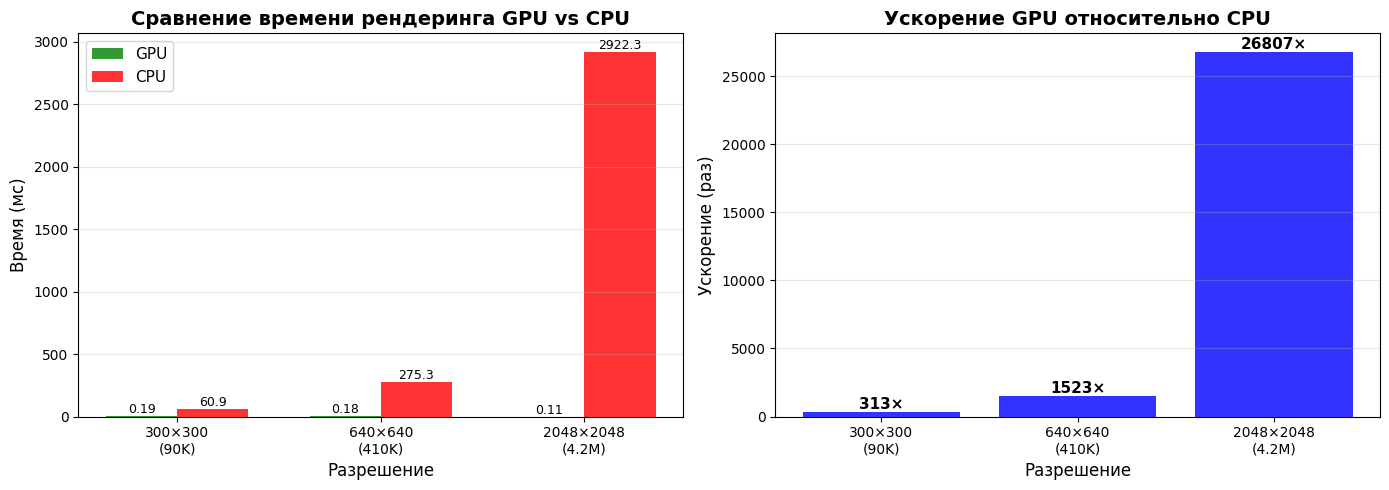

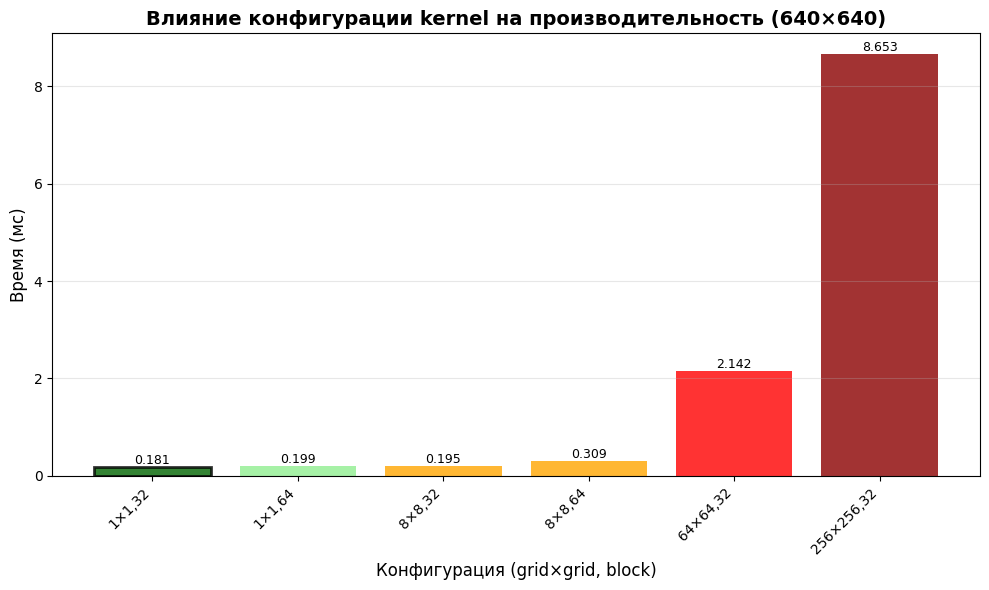

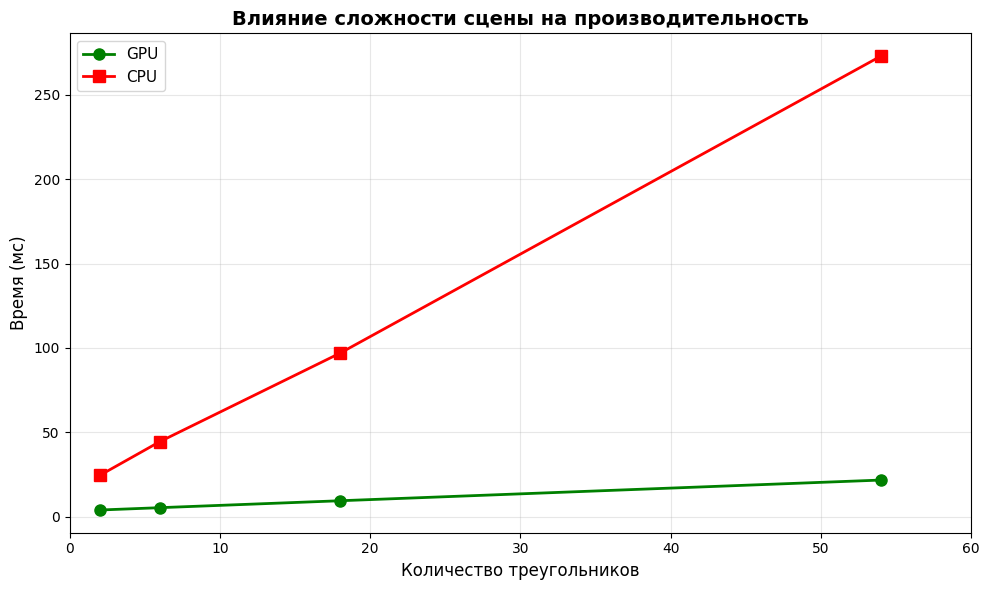

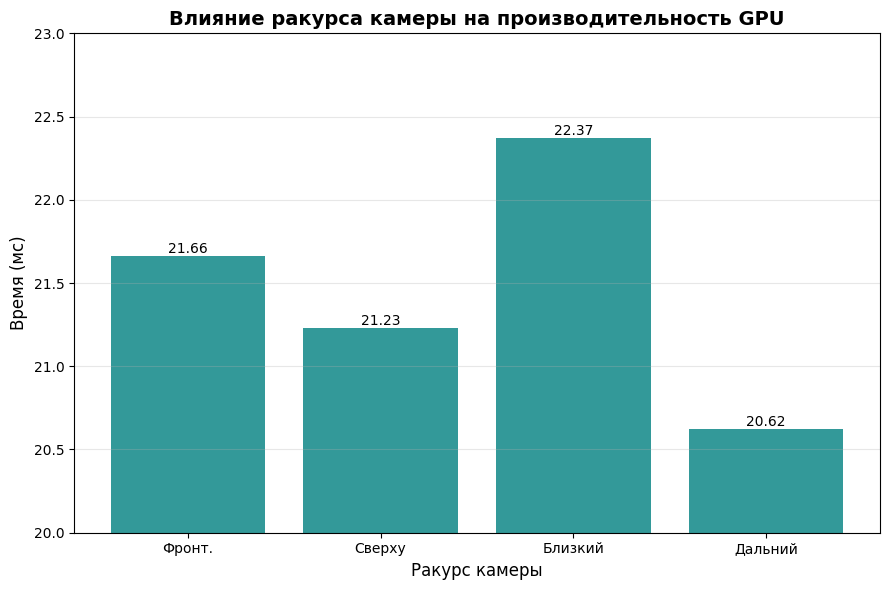

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Данные из бенчмарка
resolutions = ['300×300\n(90K)', '640×640\n(410K)', '2048×2048\n(4.2M)']
gpu_times = [0.194368, 0.180736, 0.108928]  # Оптимальные конфигурации
cpu_times = [60.945404, 275.333639, 2922.281577]
speedups = [313, 1523, 26807]

# График 1: Сравнение времени GPU vs CPU
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(resolutions))
width = 0.35

bars1 = ax1.bar(x - width/2, gpu_times, width, label='GPU', color='green', alpha=0.8)
bars2 = ax1.bar(x + width/2, cpu_times, width, label='CPU', color='red', alpha=0.8)

ax1.set_xlabel('Разрешение', fontsize=12)
ax1.set_ylabel('Время (мс)', fontsize=12)
ax1.set_title('Сравнение времени рендеринга GPU vs CPU', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(resolutions)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Добавим значения на столбцы
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=9)

# График 2: Ускорение
bars3 = ax2.bar(resolutions, speedups, color='blue', alpha=0.8)
ax2.set_xlabel('Разрешение', fontsize=12)
ax2.set_ylabel('Ускорение (раз)', fontsize=12)
ax2.set_title('Ускорение GPU относительно CPU', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}×',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('graph1_gpu_vs_cpu.png', dpi=300, bbox_inches='tight')
print("Сохранен график: graph1_gpu_vs_cpu.png")

# График 2: Влияние конфигурации kernel (для 640×640)
configs = ['1×1,32', '1×1,64', '8×8,32', '8×8,64', '64×64,32', '256×256,32']
times_640 = [0.180736, 0.199360, 0.194976, 0.308544, 2.142304, 8.652800]

plt.figure(figsize=(10, 6))
bars = plt.bar(configs, times_640, color=['green', 'lightgreen', 'orange', 'orange', 'red', 'darkred'], alpha=0.8)
plt.xlabel('Конфигурация (grid×grid, block)', fontsize=12)
plt.ylabel('Время (мс)', fontsize=12)
plt.title('Влияние конфигурации kernel на производительность (640×640)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Отметим оптимум
bars[0].set_color('darkgreen')
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('graph2_kernel_config.png', dpi=300, bbox_inches='tight')
print("Сохранен график: graph2_kernel_config.png")

# График 3: Влияние сложности сцены
triangles = [2, 6, 18, 54]
gpu_scene = [3.858208, 5.248576, 9.360128, 21.628416]
cpu_scene = [24.386116, 44.398853, 96.894558, 273.038967]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(triangles, gpu_scene, 'o-', linewidth=2, markersize=8, label='GPU', color='green')
ax.plot(triangles, cpu_scene, 's-', linewidth=2, markersize=8, label='CPU', color='red')
ax.set_xlabel('Количество треугольников', fontsize=12)
ax.set_ylabel('Время (мс)', fontsize=12)
ax.set_title('Влияние сложности сцены на производительность', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 60)

plt.tight_layout()
plt.savefig('graph3_scene_complexity.png', dpi=300, bbox_inches='tight')
print("Сохранен график: graph3_scene_complexity.png")

# График 4: Влияние ракурса
cameras = ['Фронт.', 'Сверху', 'Близкий', 'Дальний']
camera_times = [21.659649, 21.231647, 22.373953, 20.622145]

plt.figure(figsize=(9, 6))
bars = plt.bar(cameras, camera_times, color='teal', alpha=0.8)
plt.xlabel('Ракурс камеры', fontsize=12)
plt.ylabel('Время (мс)', fontsize=12)
plt.title('Влияние ракурса камеры на производительность GPU', fontsize=14, fontweight='bold')
plt.ylim(20, 23)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('graph4_camera_angle.png', dpi=300, bbox_inches='tight')
print("Сохранен график: graph4_camera_angle.png")

print("\nВсе графики успешно созданы!")

Установка gnuplot

In [7]:
!apt-get update -qq
!apt-get install -y gnuplot

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn at-spi2-core gnuplot-data gnuplot-qt gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdouble-conversion3 libevdev2 libgtk-3-0 libgtk-3-bin libgtk-3-common
  libgudev-1.0-0 libinput-bin libinput10 liblua5.4-0 libmd4c0 libmtdev1
  libnotify4 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5printsupport5 libqt5svg5 libqt5widgets5 librsvg2-common libwacom-bin
  libwacom-common libwacom9 libwxbase3.0-0v5 libwxgtk3.0-gtk3-0v5
  libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1
  libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxcomposite1
  libxkbcommon-x11-0 libxtst6 qt5-g

Скрипт для 3D визуализации сцены и траектории

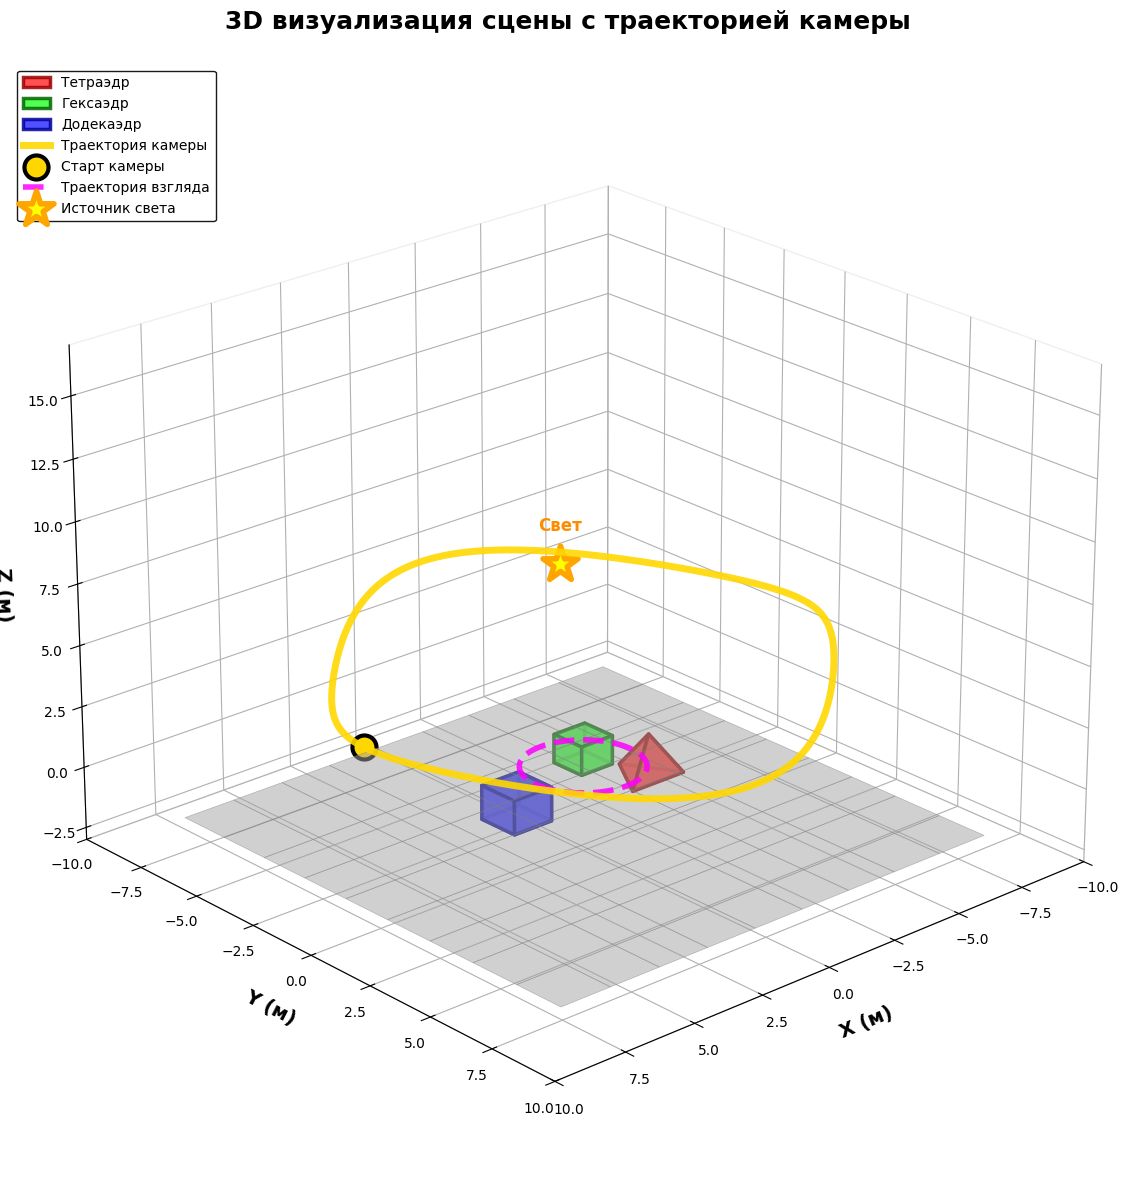

Чистый 3D график без наложений создан: graph5_3d_scene_clean.png


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Создаем фигуру
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# ============ ПОЛ (сплошной) ============
floor_x = np.linspace(-8, 8, 10)
floor_y = np.linspace(-8, 8, 10)
floor_X, floor_Y = np.meshgrid(floor_x, floor_y)
floor_Z = np.full_like(floor_X, -2)

ax.plot_surface(floor_X, floor_Y, floor_Z, alpha=0.5, color='#D3D3D3',
                edgecolor='gray', linewidth=0.5, shade=True)

# ============ ТЕТРАЭДР (красный) ============
tetra_v = np.array([
    [-2.5, 0, 0.82],
    [-3.48, 0.41, -0.98],
    [-1.52, 0.41, -0.98],
    [-2.5, -1.23, -0.98]
])
tetra_faces = [
    [tetra_v[0], tetra_v[1], tetra_v[2]],
    [tetra_v[0], tetra_v[2], tetra_v[3]],
    [tetra_v[0], tetra_v[3], tetra_v[1]],
    [tetra_v[1], tetra_v[3], tetra_v[2]]
]
tetra = Poly3DCollection(tetra_faces, alpha=0.85, facecolor='#FF3333',
                         edgecolor='#990000', linewidth=2.5, label='Тетраэдр')
ax.add_collection3d(tetra)

# ============ ГЕКСАЭДР / КУБ (зелёный) ============
cube_v = np.array([
    [-0.58, -0.58, 0.62], [0.58, -0.58, 0.62],
    [0.58, 0.58, 0.62], [-0.58, 0.58, 0.62],
    [-0.58, -0.58, 1.78], [0.58, -0.58, 1.78],
    [0.58, 0.58, 1.78], [-0.58, 0.58, 1.78]
])
cube_faces = [
    [cube_v[0], cube_v[1], cube_v[2], cube_v[3]],
    [cube_v[4], cube_v[5], cube_v[6], cube_v[7]],
    [cube_v[0], cube_v[1], cube_v[5], cube_v[4]],
    [cube_v[2], cube_v[3], cube_v[7], cube_v[6]],
    [cube_v[0], cube_v[3], cube_v[7], cube_v[4]],
    [cube_v[1], cube_v[2], cube_v[6], cube_v[5]]
]
cube = Poly3DCollection(cube_faces, alpha=0.85, facecolor='#33FF33',
                        edgecolor='#006600', linewidth=2.5, label='Гексаэдр')
ax.add_collection3d(cube)

# ============ ДОДЕКАЭДР (синий) ============
dodeca_v = np.array([
    [1.81, -0.69, -0.69], [3.19, -0.69, -0.69],
    [3.19, 0.69, -0.69], [1.81, 0.69, -0.69],
    [1.81, -0.69, 0.69], [3.19, -0.69, 0.69],
    [3.19, 0.69, 0.69], [1.81, 0.69, 0.69]
])
dodeca_faces = [
    [dodeca_v[0], dodeca_v[1], dodeca_v[2], dodeca_v[3]],
    [dodeca_v[4], dodeca_v[5], dodeca_v[6], dodeca_v[7]],
    [dodeca_v[0], dodeca_v[1], dodeca_v[5], dodeca_v[4]],
    [dodeca_v[2], dodeca_v[3], dodeca_v[7], dodeca_v[6]],
    [dodeca_v[0], dodeca_v[3], dodeca_v[7], dodeca_v[4]],
    [dodeca_v[1], dodeca_v[2], dodeca_v[6], dodeca_v[5]]
]
dodeca = Poly3DCollection(dodeca_faces, alpha=0.85, facecolor='#3333FF',
                          edgecolor='#000099', linewidth=2.5, label='Додекаэдр')
ax.add_collection3d(dodeca)

# ============ ТРАЕКТОРИЯ КАМЕРЫ (золотая спираль) ============
t = np.linspace(0, 2*np.pi, 200)
r_c = 8.0 + 1.0 * np.sin(2.0 * t)
phi_c = 1.0 * t
z_c = 4.5 + 0.6 * np.sin(3.0 * t)

cam_x = r_c * np.cos(phi_c)
cam_y = r_c * np.sin(phi_c)
cam_z = z_c

ax.plot(cam_x, cam_y, cam_z, color='#FFD700', linewidth=5,
        label='Траектория камеры', zorder=10, alpha=0.9)

# Стартовая точка камеры
ax.scatter([cam_x[0]], [cam_y[0]], [cam_z[0]], color='#FFD700', s=300,
           marker='o', edgecolors='black', linewidth=3,
           label='Старт камеры', zorder=11)

# ============ ТРАЕКТОРИЯ ВЗГЛЯДА (пурпурная окружность) ============
look_t = np.linspace(0, 2*np.pi, 100)
look_radius = 1.8  # Уменьшили радиус, чтобы не мешала
look_x = look_radius * np.cos(look_t)
look_y = look_radius * np.sin(look_t)
look_z = np.full_like(look_t, 0.5)  # Опустили ниже

ax.plot(look_x, look_y, look_z, color='#FF00FF', linewidth=4,
        linestyle='--', label='Траектория взгляда', zorder=8, alpha=0.85)

# ============ ИСТОЧНИК СВЕТА (жёлтая звезда) ============
ax.scatter([8.0], [8.0], [15.0], color='yellow', s=700, marker='*',
           edgecolors='orange', linewidth=4,
           label='Источник света', zorder=12)

# Только подпись источника света (выше звезды)
ax.text(8.0, 8.0, 16.2, 'Свет', fontsize=12, color='darkorange',
        fontweight='bold', ha='center')

# ============ НАСТРОЙКИ ГРАФИКА ============
ax.set_xlabel('X (м)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Y (м)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_zlabel('Z (м)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('3D визуализация сцены с траекторией камеры',
             fontsize=18, fontweight='bold', pad=25)

# Границы осей
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-3, 17)

# Оптимальный угол обзора
ax.view_init(elev=23, azim=48)

# Легенда (уменьшенный шрифт, компактная)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9,
          edgecolor='black', fancybox=True)

# Сетка
ax.grid(True, alpha=0.3, linestyle=':')

# Полупрозрачные панели
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#E0E0E0')
ax.yaxis.pane.set_edgecolor('#E0E0E0')
ax.zaxis.pane.set_edgecolor('#E0E0E0')

plt.tight_layout()
plt.savefig('graph5_3d_scene_clean.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("Чистый 3D график без наложений создан: graph5_3d_scene_clean.png")